# Testing degradation on ABC vs true distribution

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

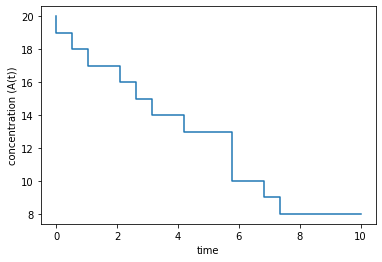

In [3]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [4]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


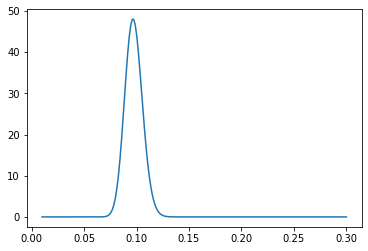

In [5]:
plt.plot(thetas, true_prob)
plt.show()

# Rejection ABC

In [99]:
error_thresholds = [10, 7, 5, 3, 1]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))

    np.random.seed(0)

    abc = pints.ABCController(error_measure, log_prior)

    # set threshold
    abc.sampler().set_threshold(error)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    print('Running...')
    samples  = abc.run()
    print('Done')

    # computing the KDE and KL functions
    def kl_func(y, post, kde_skl):
        part = posterior(values, times, y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            return np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div(x, bandwidth, posterior, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func(y, posterior, kde_skl)
        return integrate.quad(fun, 0.01, 0.3)
    
    def s_posterior(theta):
        return posterior(values, times, theta)

    t_samples = np.array([x for y in samples[:, 0] for x in y])

    resulting_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 10
Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    20     1                0:00.0
40    40     1                0:00.0
60    60     1                0:00.1
80    80     1                0:00.1
100   100    1                0:00.1
120   120    1                0:00.1
140   140    1                0:00.1
160   160    1                0:00.1
180   180    1                0:00.1
200   200    1                0:00.1
220   220    1                0:00.1
240   240    1                0:00.1
260   260    1                0:00.1
280   280    1                0:00.2
300   300    1                0:00.2
320   320    1                0:00.2
340   340    1                0:00.2
360   360    1                0:00.2
380   380    1                0:00.2
400   400    1                0:00.2
420   420    1                0:00.

[2.2490998982344266, 2.175192536888305, 1.988738495318105, 1.805903699526951, 1.7316696442139494]
[10, 7, 5, 3, 1]


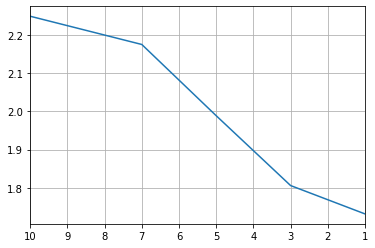

In [102]:
print(resulting_kl)
print(error_thresholds)

fig, ax = plt.subplots()

ax.plot(error_thresholds, resulting_kl)
ax.set_xlim(10, 1)
ax.grid(True)
plt.show()
res_kl_abc_rej = resulting_kl

# PMC Degradation (with smc)

In [107]:
error_thresholds = [10, 7, 5, 3, 1]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))

    np.random.seed(0)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
    # set initial threshold
    abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

    # produce intermediate distributions of size 1000
    abc.sampler().set_intermediate_size(1000)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    samples = abc.run()
    print("Done")

    # computing the KDE and KL functions
    def kl_func(y, post, kde_skl):
        part = posterior(values, times, y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            return np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div(x, bandwidth, posterior, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func(y, posterior, kde_skl)
        return integrate.quad(fun, 0.01, 0.3)
    
    def s_posterior(theta):
        return posterior(values, times, theta)

    t_samples = np.array([x for x in samples[:, 0]])

    resulting_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 10
Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=13.0
Trying t=2, threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     2001   0.000499750125   0:28.4
2     2002   0.000999000999   0:28.4
3     2003   0.00149775337    0:28.4
20    2020   0.0099009901     0:28.4
40    2040   0.0196078431     0:28.5
60    2060   0.0291262136     0:28.5
80    2080   0.0384615385     0:28.5
100   2100   0.0476190476     0:28.5
120   2120   0.0566037736     0:28.5
140   2140   0.0654205607     0:28.5
160   2160   0.0740740741     0:28.6
180   2180   0.0825688073     0:28.6
200   2200   0.0909090909     0:28.6
220   2220   0.0990990991     0:28.6
240   2240   0.107142857      0:28.6
260   2260   0.115044248      0:28.6
280   2280   0.122807018      0:28.7
300   2300   0.130434783      0:28.7
320   2320   0.137931034      0:28.7
340   2340   0.145299145      0:28.7
360   2360   0.152542373      0:28.8
380   2380   0.159663866      0:28.8
400   2400   0.166666667      0:28.

[2.244713458464493, 2.178653869868857, 1.9336254881823474, 1.7638933168524598, 1.6995293453027243]
[10, 7, 5, 3, 1]


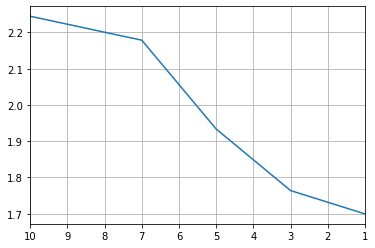

In [109]:
print(resulting_kl)
print(error_thresholds)

fig, ax = plt.subplots()

ax.plot(error_thresholds, resulting_kl)
ax.set_xlim(10, 1)
ax.grid(True)
plt.show()
res_kl_true_pmc_rej = resulting_kl

# ABC SMC

In [126]:
error_thresholds = [10, 7, 5, 3, 1]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))

    np.random.seed(0)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
    # set initial threshold
    abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

    # produce intermediate distributions of size 200
    abc.sampler().set_intermediate_size(200)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    samples = abc.run()
    print("Done")

    # computing the KDE and KL functions
    def kl_func(y, post, kde_skl):
        part = posterior(values, times, y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            return np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div(x, bandwidth, posterior, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func(y, posterior, kde_skl)
        return integrate.quad(fun, 0.01, 0.3)
    
    def s_posterior(theta):
        return posterior(values, times, theta)

    t_samples = np.array([x for x in samples[:, 0]])

    resulting_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 10
Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=13.0
Trying t=2, threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     401    0.00249376559    0:01.1
2     402    0.00497512438    0:01.1
3     403    0.00744416873    0:01.1
20    420    0.0476190476     0:01.2
40    440    0.0909090909     0:01.2
60    460    0.130434783      0:01.2
80    480    0.166666667      0:01.2
100   500    0.2              0:01.2
120   520    0.230769231      0:01.2
140   540    0.259259259      0:01.3
160   560    0.285714286      0:01.3
180   580    0.310344828      0:01.3
200   600    0.333333333      0:01.3
220   620    0.35483871       0:01.3
240   640    0.375            0:01.4
260   660    0.393939394      0:01.4
280   680    0.411764706      0:01.4
300   700    0.428571429      0:01.4
320   720    0.444444444      0:01.5
340   740    0.459459459      0:01.5
360   760    0.473684211      0:01.5
380   780    0.487179487      0:01.5
400   800    0.5              0:01.

[2.18380571482638, 2.10078051146195, 1.9449447003595148, 1.7771213397711563, 1.6956499357753316]
[10, 7, 5, 3, 1]


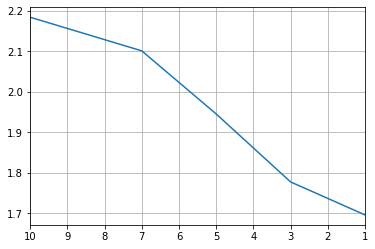

In [127]:
print(resulting_kl)
print(error_thresholds)

fig, ax = plt.subplots()

ax.plot(error_thresholds, resulting_kl)
ax.set_xlim(10, 1)
ax.grid(True)
plt.show()
res_kl_fake_pmc_rej = resulting_kl

# Compare all algorithms errors

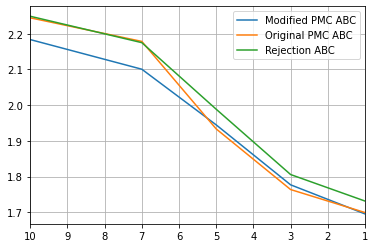

In [128]:
fig, ax = plt.subplots()

ax.plot(error_thresholds, res_kl_fake_pmc_rej, label='Modified PMC ABC')
ax.plot(error_thresholds, res_kl_true_pmc_rej, label='Original PMC ABC')
ax.plot(error_thresholds, res_kl_abc_rej, label='Rejection ABC')
ax.set_xlim(10, 1)
ax.grid(True)
ax.legend()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/degradation_errors_all.pdf')

# Adaptive PMC ABC

In [122]:
error_thresholds = [0.5, 0.4, 0.3, 0.2]
resulting_kl = []

for error in error_thresholds:
    np.random.seed(0)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

    # set threshold
    abc.sampler().set_N_l(300)

    # set p_acc_min
    abc.sampler().set_p_acc_min(error)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    print('Running...')
    samples  = abc.run()
    print('Done')

    # computing the KDE and KL functions
    def kl_func(y, post, kde_skl):
        part = posterior(values, times, y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            return np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div(x, bandwidth, posterior, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func(y, posterior, kde_skl)
        return integrate.quad(fun, 0.01, 0.3)
    
    def s_posterior(theta):
        return posterior(values, times, theta)

    t_samples = np.array([x for x in samples[:, 0]])

    resulting_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    print("finished computing kde + "+str(resulting_kl[-1]))

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.1140037]
resulting var=[[0.00372325]]
Iter. Eval. Acceptance rate Time m:s
1     2      500              0:46.1
Halting: target number of samples (1000) reached.
Done
finished computing kde + 1.9146488104105075
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.1140037]
resulting var=[[0.00372325]]
epsilon=1.7320508075688772
w_mean=[0.10753275]
resulting var=[[0.00225172]]
Iter. Eval. Acceptance rate Time m:s
1     3      333.6666666667   1:22.4
Halting: target number of samples (1001) reached.
Done
finished computing kde + 1.8396936148691785
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.1140037]
resulting var=[[0.00372325]]
epsilon=1.7320508075688772
w_mean=[0.10753275]
resulting var=[[0.00225172]]
Iter. Eval. Acceptance rate Time m:s
1     3      333.6666666667   1:19.9
Halting: target number of samples (1001) reached.
Done
finished computing kde + 1.8396936148691785

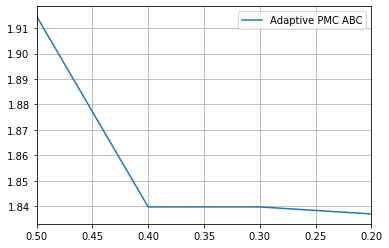

In [125]:
fig, ax = plt.subplots()

ax.plot(error_thresholds, resulting_kl, label='Adaptive PMC ABC')
ax.set_xlim(0.5, 0.2)
ax.grid(True)
ax.legend()

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

res_kl_adaptive_pmc = resulting_kl